In [1]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets, models
from PIL import Image
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm.notebook import tqdm
import csv
import ast

In [2]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
IMG_PATH = {
    "train": "data/train",
    "test": "data/test"
}
CSV_PATH = {
    "train": "data/train.csv"
}

In [4]:
#Data normalization and tensorization
def data_transform():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transform

In [5]:
#Custom dataset
class WheatDataset(data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.annotation = annotation
        self.transforms = transforms
        self.ids = os.listdir(root)
        self.anno_dict = self.make_dict()
        
    def make_dict(self):
        img_dict = {}
        with open(self.annotation) as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                if row[0] not in img_dict:
                    img_dict[row[0]] = [ast.literal_eval(row[3])]
                else:
                    img_dict[row[0]].append(ast.literal_eval(row[3]))
            return img_dict
    
    def __getitem__(self, index):
        
        
        #Open annotation file in json type
        obj_name = list(self.anno_dict.keys())[index]
        obj_boxes = self.anno_dict[obj_name]
        img_id = Image.open(os.path.join(self.root,obj_name+'.jpg'))
        
        num_obj = len(obj_boxes)
        boxes = []
        labels = []
        
        #Read in bounding boxes cordinate and labels
        for i in range(num_obj):
            xmin =  int(obj_boxes[i][0])
            ymin =  int(obj_boxes[i][1])
            xmax =  xmin + int(obj_boxes[i][2])
            ymax =  ymin + int(obj_boxes[i][3])
            label = 0
            boxes.append([xmin,ymin,xmax,ymax])
            labels.append(label)
        
        #Tensorize 
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = torch.LongTensor(labels)
        index = torch.Tensor([index])
        iscrowd = torch.zeros((num_obj,), dtype=torch.int64)
        
        #Create dict of annotation for easy access
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = index
        my_annotation["iscrowd"] = iscrowd
        my_annotation["area"] = area
        
        if self.transforms is not None:
            img = self.transforms()(img_id)
        
        return img, my_annotation
    
    def __len__(self):
        return len(self.anno_dict)
    

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [7]:
dataset = WheatDataset(IMG_PATH["train"],CSV_PATH["train"],transforms=data_transform)
dataloader = data.DataLoader(dataset,batch_size=1, shuffle=True, collate_fn=collate_fn, num_workers = 0)
TRAINING_SAMPLES =len(dataset)
print(f"Number of training samples: {TRAINING_SAMPLES}")

Number of training samples: 3373


In [8]:
#Plot tensor images
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_show = img.cpu().numpy().squeeze().transpose((1,2,0))
    img_show = (img_show * std+mean)
    img_show = np.clip(img_show,0,1)
    return img_show

C:\Users\Kay Kieran\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


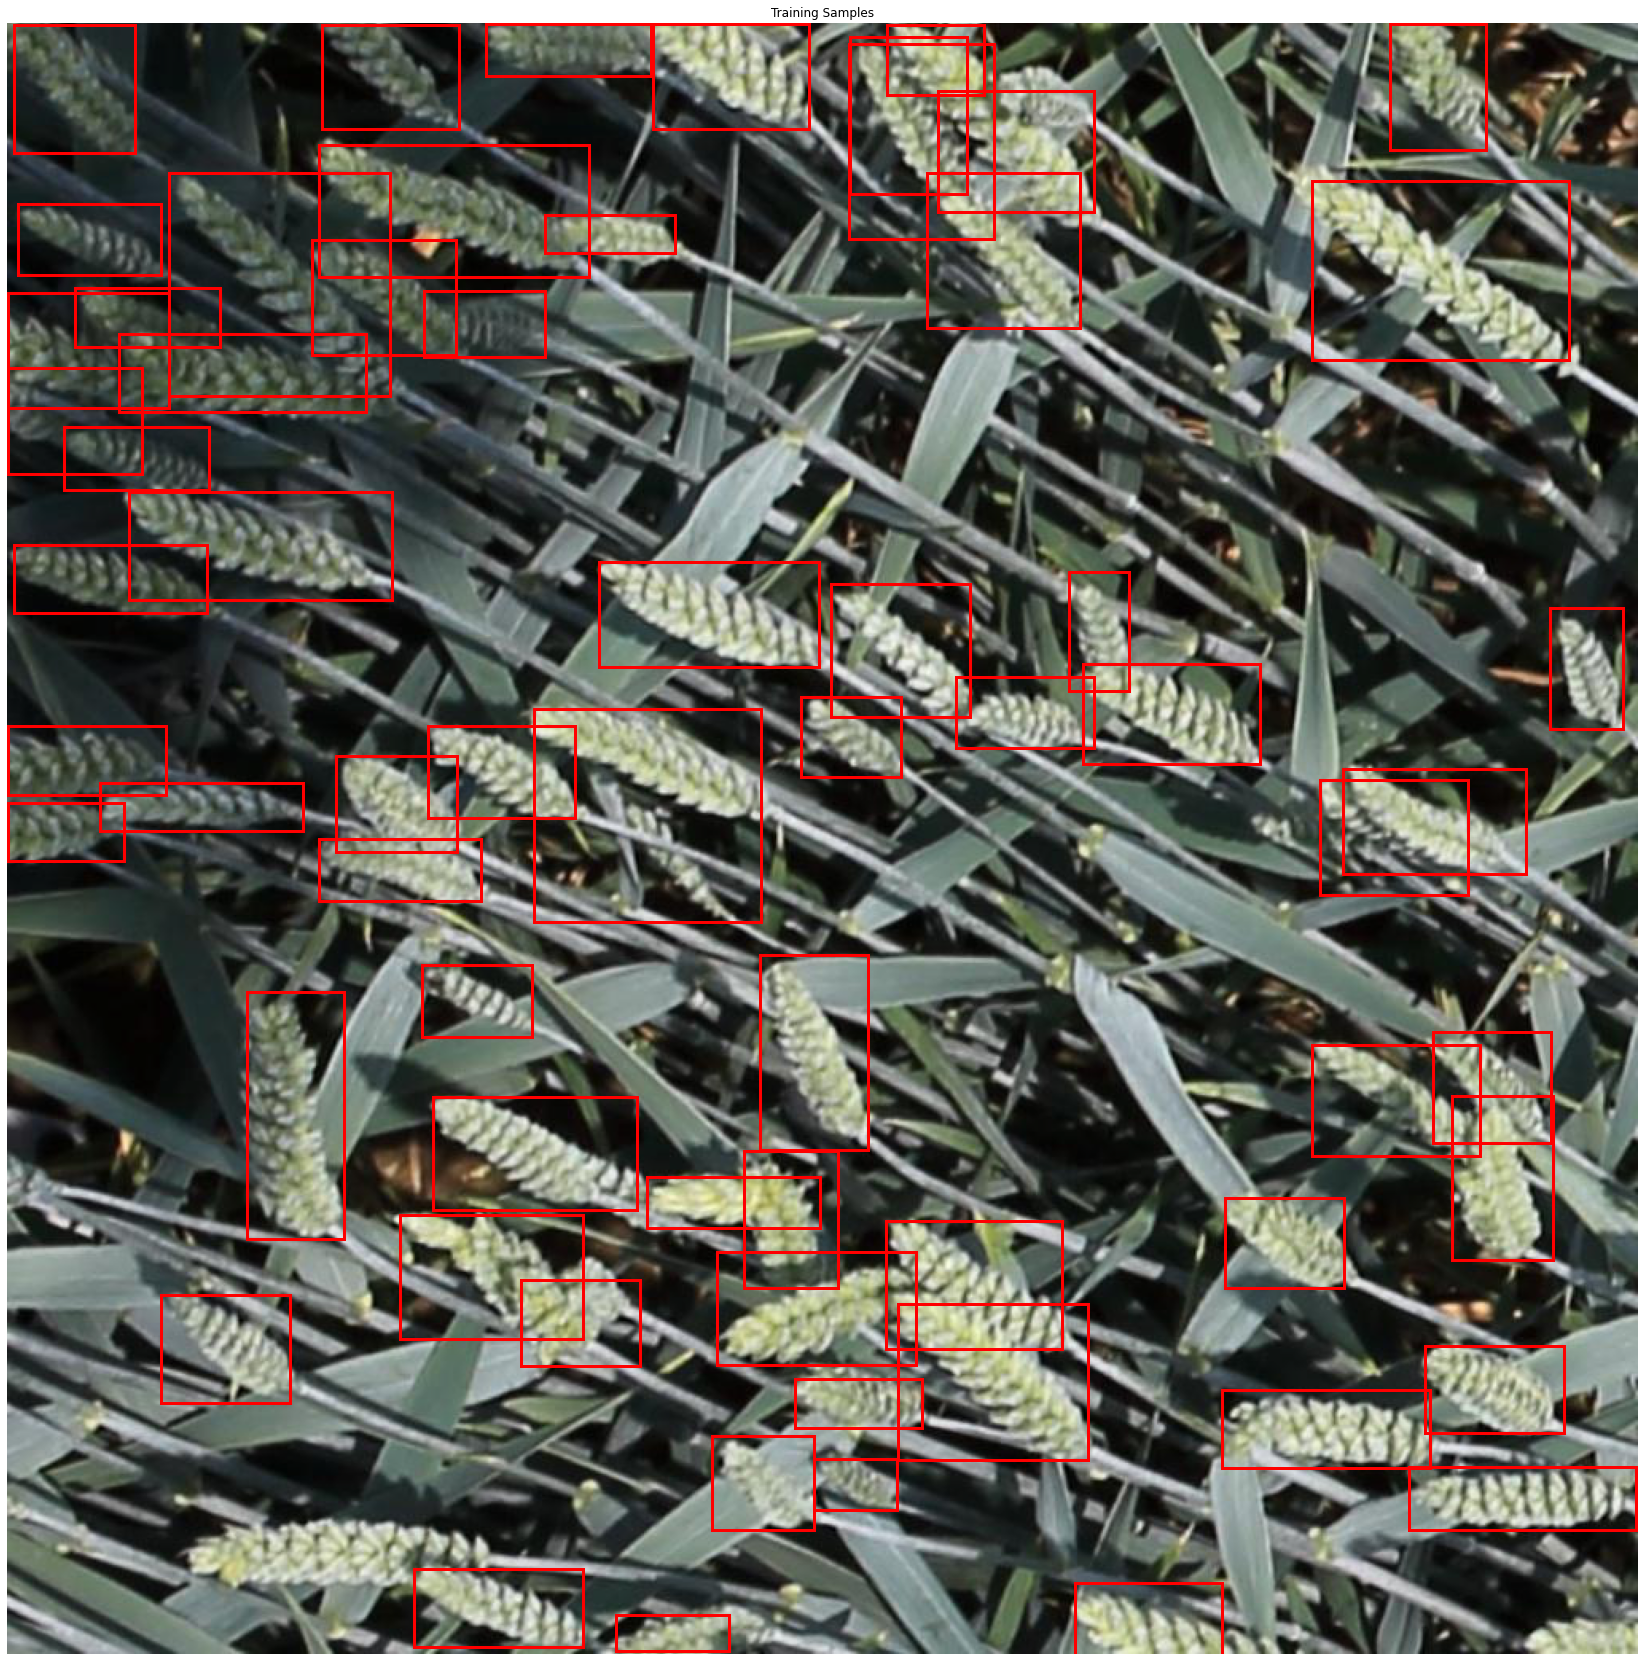

In [9]:
#Visualize 10 training samples
def visualize_samples():
    fig = plt.figure(figsize=(30,30))
    plt.axis("off")
    plt.title("Training Samples")
    for id,(img,anno) in enumerate(dataloader): 
        if id==1:
            break
        ax = fig.add_subplot(1,1,1)
        for  box in anno[0]["boxes"]:
            rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,ec="red",lw=3)
            ax.add_patch(rect)
        img = imshow(img[0])
        plt.imshow(img)
    plt.show()
visualize_samples()

In [10]:
#Create Faster R-CNN model
def instance_segmentation_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    #Edit the last layer 
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

model = instance_segmentation_model(2)
model = model.to(device)
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [11]:
#Training process
def train(model,dataloader):
    EPOCHS = 10
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
    loss_list = []
    print("Start training...")
    for epoch in range(EPOCHS):
        print("Training at epoch " + str(epoch+1)+"...")
        model.train()
        total_loss = 0
        for id, (imgs,anno) in enumerate(tqdm(dataloader)):
            optimizer.zero_grad()
            
            #Put images and annotations in list type
            imgs = list(image.to(device) for image in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in anno]
            
            #Model outputs are losses when in training mode
            loss_dict = model(imgs, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss+= losses
            
            losses.backward()
            optimizer.step()
            loss_list.append(losses)
            if (id%300 ==0 and id!=0) or id == len(dataloader)-1:
                print(f'Iteration: [{id}/{len(dataloader)}], Loss: {losses}')
            
            #Save model at every k iterations
            if id %300 == 0 or id == len(dataloader)-1:
                torch.save(model.state_dict(), "models/resnet50-244-{}-{}.pth".format(epoch+1,id))
        total_loss /= len(dataloader)
        print("Epoch: [{}/{}] | Training loss: {0:0.3f}".format(epoch+1,EPOCHS,total_loss))
    print("Training Completed!")
    
    return model, loss_list

In [12]:
def predict(model, img):
    #Set model into evaluate mode
    model.eval()
    
    #Note: PIL image dimension is h,w
    h,w = img.size
    img = data_transform()(img)
    
    #Tensor view is w,h
    imgs = Variable(img).view(-1,3,w,h).to(device)
    
    #Predict
    with torch.no_grad():
        outputs = model(imgs)
    #if torch.cuda.is_available():
        #del imgs
       # torch.cuda.empty_cache() 
    return outputs

In [13]:
model, loss_list = train(model,dataloader)

Start training...
Training at epoch 1...


Iteration: [300/3373], Loss: 1.0395770072937012
Iteration: [600/3373], Loss: 0.615786075592041
Iteration: [900/3373], Loss: 0.6126723289489746
Iteration: [1200/3373], Loss: 0.6497407555580139
Iteration: [1500/3373], Loss: 0.4461701512336731
Iteration: [1800/3373], Loss: 0.6593127250671387
Iteration: [2100/3373], Loss: 0.5268450379371643
Iteration: [2400/3373], Loss: 0.7308934926986694
Iteration: [2700/3373], Loss: 0.46577802300453186
Iteration: [3000/3373], Loss: 0.45945486426353455
Iteration: [3300/3373], Loss: 0.3664126396179199
Iteration: [3372/3373], Loss: 0.36595508456230164



ValueError: cannot switch from automatic field numbering to manual field specification

In [ ]:
model.load_state_dict(torch.load("models/resnet50-244-6-0.pth"))

In [ ]:
#Testing model
def visualize_test(model, NUM_PIC=4):
    thresh = 0.3 #Threshhold to ensure that is a digit
    fig = plt.figure(figsize=(15,15))
    a = np.random.randint(10)
    path = os.listdir(IMG_PATH["test"])
    for id,i in enumerate(path[a:a+NUM_PIC]):

        fig.add_subplot(NUM_PIC/2,2,id+1)
        
        #Open image

        img = Image.open(os.path.join(IMG_PATH["test"],i))
       
        #Predict each image at a time
        prediction = predict(model,img)
        print(prediction)
        break
        #Get top scores that pass the threshold
        scores = prediction[0]["scores"]
        scores = scores[scores >= thresh]
        num_objs = len(scores)
        
        #Get predicted bbox and label
        bboxes = prediction[0]["boxes"][:num_objs]
        labels = prediction[0]["labels"][:num_objs]
        plt.imshow(img)
        ax = plt.gca()
        plt.axis("off")
        plt.title(i)
        for box, label,score in zip(bboxes,labels,scores):
            x,y,x2,y2 = box
            label = str(label.cpu().numpy()) #+": " + "{:.3f}".format(score.cpu().numpy())
            
            #Draw bboxes
            rect = patches.Rectangle((x,y),x2-x,y2-y,color="red",lw=3,fill=False)
            #Print label
            plt.text(x,y-2,label,color="red",fontsize=10, fontweight='bold')
            ax.add_patch(rect)
            
            #These "del"s for flush cuda memory, prevent it from overloading
            if torch.cuda.is_available():
                del x,y,x2,y2,box,label,score
                torch.cuda.empty_cache()
        if torch.cuda.is_available():
            del prediction,bboxes, labels,scores
            torch.cuda.empty_cache() 
    plt.show()

In [ ]:
visualize_test(model,2)

In [ ]:
img = Image.open(os.path.join(IMG_PATH["train"],'0a3ff84a7.jpg'))
prediction = predict(model,img)
print(prediction)